In [135]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import seaborn as sns 
import matplotlib.pyplot as plt

import gensim
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from smart_open import smart_open
from numpy import random

%matplotlib inline

In [136]:
df = pd.read_csv("..//data//Womens Clothing E-Commerce Reviews Sentiment v2.csv")

In [137]:
def renames(feature, values):
    Dict_cols={}
    for value in values:
        Dict_cols[value]=feature+value
    return Dict_cols

In [138]:
## Encoding a categorical column
column_name='Division Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Division_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Division_columns)

column_name='Department Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Department_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Department_columns)

column_name='Class Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Class_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Class_columns)

In [139]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'processed_Review_text', 'PA_Polarity',
       'PA_Subjectivity', 'Division Name_General',
       'Division Name_General Petite', 'Division Name_Initmates',
       'Department Name_Bottoms', 'Department Name_Dresses',
       'Department Name_Intimate', 'Department Name_Jackets',
       'Department Name_Tops', 'Department Name_Trend', 'Class Name_Blouses',
       'Class Name_Casual bottoms', 'Class Name_Chemises',
       'Class Name_Dresses', 'Class Name_Fine gauge', 'Class Name_Intimates',
       'Class Name_Jackets', 'Class Name_Jeans', 'Class Name_Knits',
       'Class Name_Layering', 'Class Name_Legwear', 'Class Name_Lounge',
       'Class Name_Outerwear', 'Class Name_Pants', 'Class Name_Shorts',
       'Class Name_Skirts', 'Class Name_Sleep', 'Class Name_Sweaters',
       'Class Name_Swim', 'Class Name_Trend'],


In [141]:
## Discarding a empty reviews & removing the other columns

df=df[((df.processed_Review_text.isna()==False) & (df.processed_Review_text.isnull()==False) & (df.processed_Review_text!=""))]

In [148]:
# TF IDF Conversion
vectorizer = TfidfVectorizer()
Recommended_vectors = vectorizer.fit_transform(df["processed_Review_text"][df['Recommended IND']==1])
Recommended_df = pd.DataFrame(Recommended_vectors.toarray(), columns = vectorizer.get_feature_names())

vectorizer = TfidfVectorizer()
NotRecommended_vectors = vectorizer.fit_transform(df["processed_Review_text"][df['Recommended IND']==0])
NotRecommended_df = pd.DataFrame(NotRecommended_vectors.toarray(), columns = vectorizer.get_feature_names())



In [149]:
Recommended_df.head()

,00p0p,0regular,0xs,100s,10m,10m34c,10medium,10the,10yr,112lbs,...,zipepr,ziploc,zipped,zipper,zippered,zippie,zipping,zone,zoom,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# TF IDF Conversion
vectorizer = TfidfVectorizer()
review_vectors = vectorizer.fit_transform(df["processed_Review_text"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())
review_columns= vectorizer.get_feature_names()

In [80]:
features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df=pd.concat([df,features_df], axis=1,ignore_index=False)

In [81]:
df=df.drop(columns=['Clothing ID','Title','Division Name', 'Department Name', 'Class Name','Positive Feedback Count','Review Text','processed_Review_text'])

In [82]:
InputFeature=df.columns.tolist()
OutputFeature='Recommended IND'
InputFeature.remove(OutputFeature)

In [129]:
## For Hyper parameter selection used Grid Search


def param_selection(model,param_grid, nfolds=3):
#     print(str(datetime.datetime.now())+" : Starting Param selection")
    grid_search = GridSearchCV(model, param_grid, cv=nfolds,verbose =1)
    grid_search.fit( df[InputFeature], df[OutputFeature])
    print("Best Parmater for model : "+ str(grid_search.best_params_))
#     print(str(datetime.datetime.now())+" : Param selection is completed")
    return grid_search.best_estimator_

def Category_coefs(modelbest_estimator,columnslist, ImpFtrShow=0):
    # Coeffiencents
    coefs=pd.DataFrame({'Featrures':InputFeature, 'Coeff':modelbest_estimator.coef_[0]})
    coefs=coefs[coefs['Featrures'].isin(columnslist)]
    if ImpFtrShow==0 or ImpFtrShow*2>len(coefs['Featrures']) :
        title= 'Features of Coeff''s '
    else:
        ## Accounting both positive & negative important coefficients
        coefs=pd.concat([coefs.sort_values(by=['Coeff'],ascending=False).head(ImpFtrShow),coefs.sort_values(by=['Coeff'],ascending=False).tail(ImpFtrShow)])
        title='Top & Bottom '+str(ImpFtrShow)+' Features of Coeff''s '
    #fig, ax = plt.subplots(figsize=(10,4))
    plt.bar(coefs['Featrures'], coefs['Coeff'])
    plt.xticks(rotation=70)
    plt.title(title)


def model_experiment(model,param_grid, nfolds=[3,3], ImpFtrShow=3):
    ## Parameters ##
    ## model - Input model
    ## param_grid - model parameters in dict type to find best one, if no need to find - pass empty dict value
    ## nfolds - 1st value :GridSearchCV nfold value, 2nd value - Cross Validation nfold value. if you want to proceed with holdout validation, pass 0 in 2nd parameter
    ## ImpFtrShow - Number of attribute to show
    
    
    print("*******", type(model).__name__,"*****")
    
    datetime_start=datetime.datetime.now()
    
    print(str(datetime.datetime.now())+" : Starting the model experiments")
    if len(param_grid)==0:
        ## Spliting the train & test data
        X_train, X_test, y_train, y_test = train_test_split(df[InputFeature], df[OutputFeature],  test_size=0.2, random_state=0)
        
        # Fitting a model based on given parameter
        modelbest_estimator=model
        modelbest_estimator.fit(X_train,y_train)
        
        datetime_modelfit=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model Fitting completed in "+ str(minutes_diff) + " minutes ")
    else:
        ## Experimenting model with different parameters
        modelbest_estimator=param_selection(model,param_grid,nfolds[0])
        
        datetime_modelfit=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model GridSearch CV completed in "+ str(minutes_diff) + " minutes ")

    plt.subplots(figsize=(10,4))
    
    if nfolds[1]<=1:
        y_pred = modelbest_estimator.predict(X_test)
        y=y_test
        print('Accuracy Score : '+str(metrics.accuracy_score(y,y_pred )))
        print('precision  : '+str(metrics.precision_score(y,y_pred ))) 
        print('recall  : '+str(metrics.recall_score(y,y_pred ))) 
        print('AUC  : '+str(metrics.roc_auc_score(y, y_pred)))
    else:
        ## Cross Validation 
        
        scores=cross_val_score(modelbest_estimator, df[InputFeature], df[OutputFeature], cv=nfolds[1], scoring="accuracy")
        plt.subplot(1,2,1)
        pd.Series(scores).plot(kind="box", label="Accuracy");
        plt.title('RMSE from 5 Folds')

        print("Cross Validation Accuracy Scores "+str(scores))
        print("Cross Validation Accuracy Mean Score "+str(np.mean(scores, dtype=np.float64)))
        
        scores=cross_val_score(modelbest_estimator, df[InputFeature], df[OutputFeature], cv=nfolds[1], scoring="roc_auc")
        print("Cross Validation Accuracy AUC Score "+str(np.mean(scores, dtype=np.float64)))

        datetime_cv=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model Cross Validation completed in "+ str(minutes_diff) + " minutes ")

        ## Validating the model
        y_pred = modelbest_estimator.predict(df[InputFeature])
        y=df[OutputFeature]
        
    ## Confusion Matrix 
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d',xticklabels=['No','Yes'], yticklabels=['No','Yes'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    plt.subplots(figsize=(12,4))
    Category_coefs(modelbest_estimator,df.columns,ImpFtrShow*2)
    
    plt.subplots(figsize=(10,8))    
    
    # Coeffiencents
    plt.subplot(2,2,1)
    Category_coefs(modelbest_estimator,df.columns[df.columns.isin(list(Division_columns.values()))],ImpFtrShow)
    plt.subplot(2,2,2)
    Category_coefs(modelbest_estimator,df.columns[df.columns.isin(list(Department_columns.values()))],ImpFtrShow)
    plt.subplot(2,2,3)
    Category_coefs(modelbest_estimator,df.columns[df.columns.isin(list(Class_columns.values()))],ImpFtrShow)
    plt.subplot(2,2,4)
    Category_coefs(modelbest_estimator,df.columns[df.columns.isin(review_columns)],ImpFtrShow)
    plt.tight_layout()
    

******* LogisticRegression *****
2019-08-22 20:30:35.692041 : Starting the model experiments
Model Fitting completed in 0.27 minutes 
Accuracy Score : 0.9342018105542063
precision  : 0.95620239390642
recall  : 0.962486308871851
AUC  : 0.8894529605932802


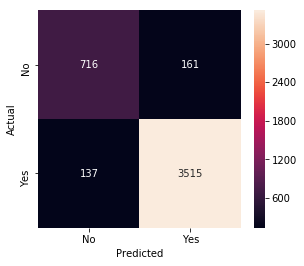

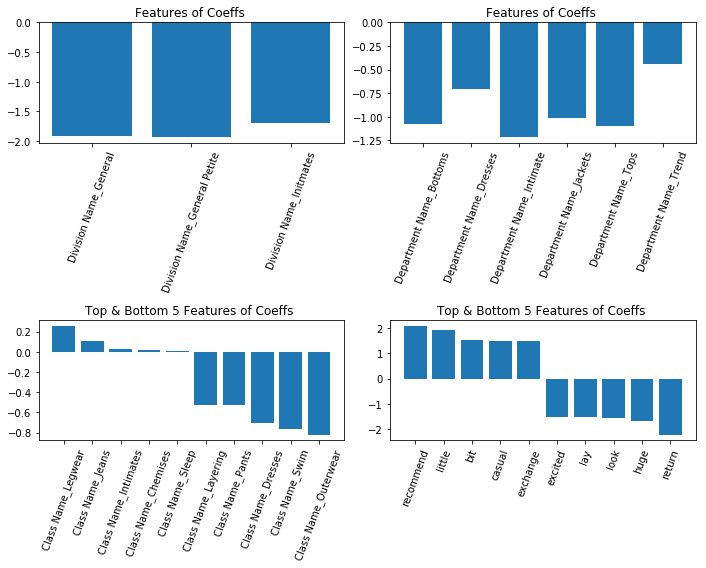

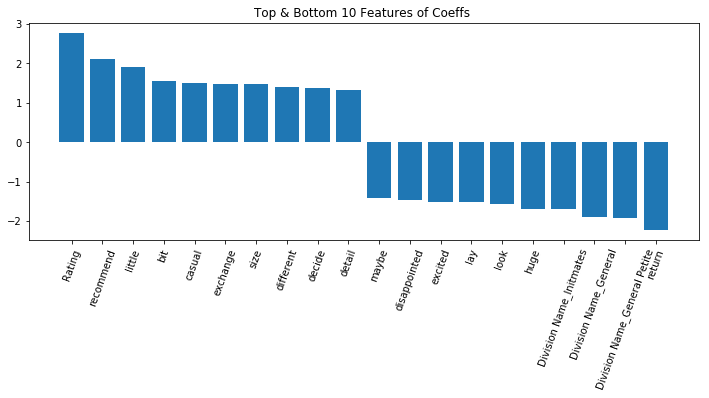

In [130]:
model=linear_model.LogisticRegression(n_jobs=1, solver='liblinear', C=1, penalty='l2', max_iter=1000)
param_grid={}#{'C':[0.01,1,100,1000]} 

coefs=model_experiment(model,param_grid,[2,0],5)